In [1]:
import numpy as np
import pandas as pd
from psutil import virtual_memory
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# 1) Read the data

In [2]:
DATA_PATH = '/home/victor/Aero_TFG/analysedData/'

In [3]:
df = pd.read_csv(DATA_PATH + 'signal.csv', sep='|')

In [4]:
df.head(5)

,FL_DATE,HOUR,OD_PAIR,DEP_DELAY,ARR_DELAY,MEDIAN_ARR_DELAY,MEDIAN_DEP_DELAY,MEAN_ARR_DELAY,MEAN_DEP_DELAY,DAY,DAY_OF_WEEK,MONTH,QUARTER,YEAR
0,2018-01-01,0,ANC_SEA,"[12.0, -10.0]",[],NaN,1.0,NaN,1.0,1,0,1,1,2018
1,2018-01-01,0,ATL_AUS,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,1,2018
2,2018-01-01,0,ATL_BNA,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,1,2018
3,2018-01-01,0,ATL_BOS,"[14.0, -4.0]","[-9.0, -15.0, 86.0]",-9.0,5.0,20.666667,5.0,1,0,1,1,2018
4,2018-01-01,0,ATL_BWI,NaN,NaN,NaN,NaN,NaN,NaN,1,0,1,1,2018


In [5]:
df.rename(columns={'MEDIAN_DEP_DELAY': 'MEDIAN_DELAY'}, inplace=True)

In [6]:
df = df[['YEAR', 'FL_DATE', 'HOUR', 'DAY', 'DAY_OF_WEEK', 'MONTH', 'QUARTER', 'OD_PAIR', 'MEDIAN_DELAY']]
df.head()

,YEAR,FL_DATE,HOUR,DAY,DAY_OF_WEEK,MONTH,QUARTER,OD_PAIR,MEDIAN_DELAY
0,2018,2018-01-01,0,1,0,1,1,ANC_SEA,1.0
1,2018,2018-01-01,0,1,0,1,1,ATL_AUS,NaN
2,2018,2018-01-01,0,1,0,1,1,ATL_BNA,NaN
3,2018,2018-01-01,0,1,0,1,1,ATL_BOS,5.0
4,2018,2018-01-01,0,1,0,1,1,ATL_BWI,NaN


In [7]:
df['MEDIAN_DELAY'] = df['MEDIAN_DELAY'].fillna(-1)

In [8]:
def get_season(month):
    if month in range(9,12):
        return 1                # September - November -- Low delays
    elif month in range(1, 6):
        return 2                # January - May -- Medium delays
    elif month in range(6, 9) or month == 12:
        return 3                # June - August or December -- High delays
    return month

df['SEASON'] = df['MONTH'].apply(get_season)
df.drop(columns=['MONTH'], inplace=True)

In [9]:
od_pairs = np.array(sorted(df['OD_PAIR'].unique()))
dates = np.array(sorted(df['FL_DATE'].unique()))
df.drop(columns=['FL_DATE'], inplace=True)
hours = np.array(sorted(df['HOUR'].unique()))
od_pairs.shape

(344,)

In [10]:
# Calculating 100 most delayed OD_PAIRS
gb_odpairs_meandel = (df.groupby('OD_PAIR')['MEDIAN_DELAY']).agg('mean').sort_values(ascending=False)
print(gb_odpairs_meandel.head())
most_delayed_od = list(gb_odpairs_meandel.index[0:100])
most_delayed_od[0:5]

OD_PAIR
MCO_EWR    6.982803
ORD_LGA    6.008500
DAL_HOU    5.871561
ATL_EWR    5.739289
ORD_SFO    5.708186
Name: MEDIAN_DELAY, dtype: float64


['MCO_EWR', 'ORD_LGA', 'DAL_HOU', 'ATL_EWR', 'ORD_SFO']

# Get clustering

In [11]:
# Apply clustering to each hour
n_clust = 6
random_state = 42
n_hours = dates.shape[0]*hours.shape[0]
kmeans_h = KMeans(n_clusters=n_clust, random_state=42)

kmeans_h.fit(df['MEDIAN_DELAY'].values.reshape(n_hours, -1))
df['HOUR_CLUSTER'] = np.repeat(kmeans_h.labels_, od_pairs.shape[0])

In [12]:
# Apply clustering to each day
n_clust = 6
random_state = 42
kmeans_d = KMeans(n_clusters=n_clust, random_state=42)

kmeans_d.fit(df['MEDIAN_DELAY'].values.reshape(dates.shape[0], -1))
df['DAY_CLUSTER'] = np.repeat(kmeans_d.labels_, hours.shape[0]*od_pairs.shape[0])

In [13]:
df['DAY_CLUSTER-1'] = df['DAY_CLUSTER'].shift(-hours.shape[0]*od_pairs.shape[0], fill_value=1)

# Obtaining rest of features

In [14]:
df['MED_DELAY-1'] = df['MEDIAN_DELAY'].shift(-od_pairs.shape[0], fill_value=0)

# Obtaining labels

In [15]:
th = 60
h = 2

df_signal_shifted = df['MEDIAN_DELAY'].shift(-h*od_pairs.shape[0]).fillna(-1)

df['y'] = 1*(df_signal_shifted.values >= th)

In [16]:
df.head()

,YEAR,HOUR,DAY,DAY_OF_WEEK,QUARTER,OD_PAIR,MEDIAN_DELAY,SEASON,HOUR_CLUSTER,DAY_CLUSTER,DAY_CLUSTER-1,MED_DELAY-1,y
0,2018,0,1,0,1,ANC_SEA,1.0,2,1,2,2,-1.0,0
1,2018,0,1,0,1,ATL_AUS,-1.0,2,1,2,2,-1.0,0
2,2018,0,1,0,1,ATL_BNA,-1.0,2,1,2,2,-1.0,0
3,2018,0,1,0,1,ATL_BOS,5.0,2,1,2,2,-1.0,0
4,2018,0,1,0,1,ATL_BWI,-1.0,2,1,2,2,-1.0,0


### Downcast columns to save memory

In [17]:
df.memory_usage().sum()/(1024*1024)

307.1309814453125

In [18]:
for c in df.columns:
    if 'float' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='float')
    elif 'int' in str(df[c].dtype):
        df[c] = pd.to_numeric(df[c], downcast='integer')

In [19]:
df.memory_usage().sum()/(1024*1024)

90.1363525390625

In [20]:
df.dtypes

YEAR               int16
HOUR                int8
DAY                 int8
DAY_OF_WEEK         int8
QUARTER             int8
OD_PAIR           object
MEDIAN_DELAY     float32
SEASON              int8
HOUR_CLUSTER        int8
DAY_CLUSTER         int8
DAY_CLUSTER-1       int8
MED_DELAY-1      float32
y                   int8
dtype: object

# 1) Testing OD pair indicator (One Hot)

In [21]:
df_indic = pd.get_dummies(df)

In [22]:
df_indic.dtypes

YEAR               int16
HOUR                int8
DAY                 int8
DAY_OF_WEEK         int8
QUARTER             int8
                   ...  
OD_PAIR_SNA_PHX    uint8
OD_PAIR_SNA_SJC    uint8
OD_PAIR_STL_ATL    uint8
OD_PAIR_STL_LGA    uint8
OD_PAIR_TPA_ATL    uint8
Length: 356, dtype: object

In [23]:
df_train = df_indic[df_indic['YEAR'] == 2018].drop(columns=['YEAR'])
df_test = df_indic[df_indic['YEAR'] == 2019].drop(columns=['YEAR'])

In [24]:
sample_size = sum(df_train['y'] == 1)
random_indices = np.random.choice(df_train[df_train['y'] == 0].index, sample_size, replace=False)
idx = np.concatenate([random_indices, df_train[df_train['y'] == 1].index])

In [25]:
cols_data = list(df_train.columns)
cols_data.remove('y')
X = df_train.loc[idx, cols_data].values
y = df_train.loc[idx, 'y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying model

In [26]:
model_rf = RandomForestClassifier(random_state=0,
                                  criterion='gini',
                                  n_estimators=100, 
                                  max_depth=5,
                                  min_samples_leaf=100,
                                  max_features=100).fit(X_train, y_train)

### Testing balanced dataset

In [27]:
y_pred_rf = model_rf.predict(X_test)

In [28]:
acc_rf_bal = accuracy_score(y_test, y_pred_rf)
prec_rf_bal = precision_score(y_test, y_pred_rf)
rec_rf_bal = recall_score(y_test, y_pred_rf)
f1_rf_bal = f1_score(y_test, y_pred_rf)

In [29]:
print(acc_rf_bal)
print(prec_rf_bal)
print(rec_rf_bal)
print(f1_rf_bal)

0.7190265486725663
0.7442220502045781
0.6560093576371966
0.697337063516734


### Testing unbalanced dataset

In [30]:
y_test = df_test['y'].values
X_test = scaler.transform(df_test.drop(columns='y').values)

In [31]:
y_pred_rf = model_rf.predict(X_test)

In [32]:
acc_rf_unbal = accuracy_score(y_test, y_pred_rf)
prec_rf_unbal = precision_score(y_test, y_pred_rf)
rec_rf_unbal = recall_score(y_test, y_pred_rf)
f1_rf_unbal = f1_score(y_test, y_pred_rf)

In [33]:
print(acc_rf_unbal)
print(prec_rf_unbal)
print(rec_rf_unbal)
print(f1_rf_unbal)

0.768932301931415
0.05462689163332753
0.619672454617206
0.10040282617730745


### Feature importance

In [34]:
assert len(cols_data) == len(model_rf.feature_importances_)

In [35]:
for name, fi in zip(cols_data, model_rf.feature_importances_):
    print("Name {}, fi {}".format(name, fi))


Name HOUR, fi 0.3094310558475829
Name DAY, fi 0.0030045024830002327
Name DAY_OF_WEEK, fi 0.006389507265706642
Name QUARTER, fi 0.005399254040935884
Name MEDIAN_DELAY, fi 0.07616254840112771
Name SEASON, fi 0.018116967113434086
Name HOUR_CLUSTER, fi 0.266332276997734
Name DAY_CLUSTER, fi 0.24608927088489824
Name DAY_CLUSTER-1, fi 0.008355578846062004
Name MED_DELAY-1, fi 0.0599907592831366
Name OD_PAIR_ANC_SEA, fi 0.0
Name OD_PAIR_ATL_AUS, fi 0.0
Name OD_PAIR_ATL_BNA, fi 0.0
Name OD_PAIR_ATL_BOS, fi 0.0
Name OD_PAIR_ATL_BWI, fi 0.0
Name OD_PAIR_ATL_CLT, fi 0.0
Name OD_PAIR_ATL_CMH, fi 0.0
Name OD_PAIR_ATL_DCA, fi 0.0
Name OD_PAIR_ATL_DEN, fi 0.0
Name OD_PAIR_ATL_DFW, fi 0.0
Name OD_PAIR_ATL_DTW, fi 0.0
Name OD_PAIR_ATL_EWR, fi 0.0
Name OD_PAIR_ATL_FLL, fi 0.0
Name OD_PAIR_ATL_GSP, fi 0.0
Name OD_PAIR_ATL_HOU, fi 0.0
Name OD_PAIR_ATL_IAD, fi 0.0
Name OD_PAIR_ATL_IAH, fi 0.0
Name OD_PAIR_ATL_IND, fi 0.0
Name OD_PAIR_ATL_JAX, fi 0.0
Name OD_PAIR_ATL_LAS, fi 0.0
Name OD_PAIR_ATL_LAX, fi 0.0

# 2) All od_pairs information

In [36]:
virtual_memory()

svmem(total=16701898752, available=10322104320, percent=38.2, used=5950230528, free=9736511488, active=5413601280, inactive=1199247360, buffers=48463872, cached=966692864, shared=129769472, slab=179109888)

In [37]:
del df_train, df_test, df_indic, X_train, X_test, y_train, y_test, y_pred_rf

In [38]:
virtual_memory()

svmem(total=16701898752, available=13754859520, percent=17.6, used=2517475328, free=13169266688, active=1987526656, inactive=1199247360, buffers=48480256, cached=966676480, shared=129769472, slab=179109888)

In [39]:
med_delays_odpairs = df['MEDIAN_DELAY'].values.reshape(-1, od_pairs.shape[0]).astype(np.float32)

In [40]:
cols_all_delays = [od + '_MED_DELAY' for od in od_pairs]
df.drop(columns=['MEDIAN_DELAY', 'MED_DELAY-1'], inplace=True)

df = pd.concat([df, pd.DataFrame(np.repeat(med_delays_odpairs, od_pairs.shape[0], axis=0).astype(np.float32), columns=cols_all_delays)], axis=1)

In [41]:
df.head()

,YEAR,HOUR,DAY,DAY_OF_WEEK,QUARTER,OD_PAIR,SEASON,HOUR_CLUSTER,DAY_CLUSTER,DAY_CLUSTER-1,...,SLC_PHX_MED_DELAY,SLC_SEA_MED_DELAY,SMF_LAX_MED_DELAY,SMF_SAN_MED_DELAY,SMF_SEA_MED_DELAY,SNA_PHX_MED_DELAY,SNA_SJC_MED_DELAY,STL_ATL_MED_DELAY,STL_LGA_MED_DELAY,TPA_ATL_MED_DELAY
0,2018,0,1,0,1,ANC_SEA,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2018,0,1,0,1,ATL_AUS,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2018,0,1,0,1,ATL_BNA,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2018,0,1,0,1,ATL_BOS,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2018,0,1,0,1,ATL_BWI,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [42]:
df.memory_usage().sum()/(1024*1024)

4657.0386962890625

In [43]:
virtual_memory()

svmem(total=16701898752, available=8931549184, percent=46.5, used=7340937216, free=8345882624, active=6801129472, inactive=1199276032, buffers=48529408, cached=966549504, shared=129662976, slab=179109888)

## Adding airport data

## Testing the model

In [44]:
df_train = df[df['YEAR'] == 2018].drop(columns=['YEAR', 'OD_PAIR'])
df_test = df[df['YEAR'] == 2019].drop(columns=['YEAR', 'OD_PAIR'])

In [45]:
sample_size = sum(df_train['y'] == 1)
random_indices = np.random.choice(df_train[df_train['y'] == 0].index, sample_size, replace=False)
idx = np.concatenate([random_indices, df_train[df_train['y'] == 1].index])

In [46]:
cols_data = list(df_train.columns)
cols_data.remove('y')
X = df_train.loc[idx, cols_data].values
y = df_train.loc[idx, 'y'].values
del df_train

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Applying model

In [47]:
model_rf = RandomForestClassifier(random_state=0,
                                  criterion='gini',
                                  n_estimators=100, 
                                  max_depth=5,
                                  min_samples_leaf=100,
                                  max_features=100).fit(X_train, y_train)

### Testing balanced dataset

In [48]:
y_pred_rf = model_rf.predict(X_test)

In [49]:
acc_rf_bal = accuracy_score(y_test, y_pred_rf)
prec_rf_bal = precision_score(y_test, y_pred_rf)
rec_rf_bal = recall_score(y_test, y_pred_rf)
f1_rf_bal = f1_score(y_test, y_pred_rf)

In [50]:
print(acc_rf_bal)
print(prec_rf_bal)
print(rec_rf_bal)
print(f1_rf_bal)

0.7126298576375529
0.7305705059203444
0.6615654547226826
0.69435776766075


### Testing unbalanced dataset

In [51]:
y_test = df_test['y'].values
X_test = scaler.transform(df_test.drop(columns='y').values)

In [52]:
y_pred_rf = model_rf.predict(X_test)

In [53]:
acc_rf_unbal = accuracy_score(y_test, y_pred_rf)
prec_rf_unbal = precision_score(y_test, y_pred_rf)
rec_rf_unbal = recall_score(y_test, y_pred_rf)
f1_rf_unbal = f1_score(y_test, y_pred_rf)

In [54]:
print(acc_rf_unbal)
print(prec_rf_unbal)
print(rec_rf_unbal)
print(f1_rf_unbal)

0.7244366706083301
0.04681839429706673
0.6323993685872139
0.08718241662586368


### Feature importance

In [55]:
assert len(cols_data) == len(model_rf.feature_importances_)

In [56]:
for name, fi in zip(cols_data, model_rf.feature_importances_):
    print("Name {}, fi {}".format(name, fi))


Name HOUR, fi 0.1781324184302585
Name DAY, fi 8.120224998218567e-06
Name DAY_OF_WEEK, fi 4.971275825642256e-05
Name QUARTER, fi 1.1400711264757067e-05
Name SEASON, fi 0.00024079910256539854
Name HOUR_CLUSTER, fi 0.11657753973517929
Name DAY_CLUSTER, fi 0.11321441077261922
Name DAY_CLUSTER-1, fi 6.04449954525169e-07
Name ANC_SEA_MED_DELAY, fi 3.573920737001492e-05
Name ATL_AUS_MED_DELAY, fi 0.0
Name ATL_BNA_MED_DELAY, fi 0.00010046635211352014
Name ATL_BOS_MED_DELAY, fi 0.00010411863048360615
Name ATL_BWI_MED_DELAY, fi 0.0001785160794818248
Name ATL_CLT_MED_DELAY, fi 8.762089649313887e-05
Name ATL_CMH_MED_DELAY, fi 6.136611413886639e-06
Name ATL_DCA_MED_DELAY, fi 4.942763713263779e-05
Name ATL_DEN_MED_DELAY, fi 1.0121446790401365e-05
Name ATL_DFW_MED_DELAY, fi 0.00029416717391149487
Name ATL_DTW_MED_DELAY, fi 0.00023895727704116606
Name ATL_EWR_MED_DELAY, fi 0.0007459136309036533
Name ATL_FLL_MED_DELAY, fi 0.0001826150747163097
Name ATL_GSP_MED_DELAY, fi 0.0
Name ATL_HOU_MED_DELAY, fi 6

# Testing on 100 most delayed OD pairs

In [57]:
df.head()

,YEAR,HOUR,DAY,DAY_OF_WEEK,QUARTER,OD_PAIR,SEASON,HOUR_CLUSTER,DAY_CLUSTER,DAY_CLUSTER-1,...,SLC_PHX_MED_DELAY,SLC_SEA_MED_DELAY,SMF_LAX_MED_DELAY,SMF_SAN_MED_DELAY,SMF_SEA_MED_DELAY,SNA_PHX_MED_DELAY,SNA_SJC_MED_DELAY,STL_ATL_MED_DELAY,STL_LGA_MED_DELAY,TPA_ATL_MED_DELAY
0,2018,0,1,0,1,ANC_SEA,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,2018,0,1,0,1,ATL_AUS,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,2018,0,1,0,1,ATL_BNA,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,2018,0,1,0,1,ATL_BOS,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,2018,0,1,0,1,ATL_BWI,2,1,2,2,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [58]:
def make_test(df_od):
    
    df_train = df_od[df_od['YEAR'] == 2018].drop(columns=['YEAR', 'OD_PAIR'])
    df_test = df_od[df_od['YEAR'] == 2019].drop(columns=['YEAR', 'OD_PAIR'])
    
    sample_size = sum(df_train['y'] == 1)
    random_indices = np.random.choice(df_train[df_train['y'] == 0].index, sample_size, replace=False)
    idx = np.concatenate([random_indices, df_train[df_train['y'] == 1].index])
    
    cols_data = list(df_train.columns)
    cols_data.remove('y')
    #print(df_train.head())
    X = df_train.loc[idx, cols_data].values
    y = df_train.loc[idx, 'y'].values
    del df_train

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = MinMaxScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    model_rf = RandomForestClassifier(random_state=0,
                                      criterion='gini',
                                      n_estimators=100, 
                                      max_depth=5,
                                      min_samples_leaf=100,
                                      max_features='auto').fit(X_train, y_train)
    
    results = dict()
    y_pred_rf = model_rf.predict(X_test)
    results['acc_rf_bal'] = accuracy_score(y_test, y_pred_rf)
    results['prec_rf_bal'] = precision_score(y_test, y_pred_rf)
    results['rec_rf_bal'] = recall_score(y_test, y_pred_rf)
    results['f1_rf_bal'] = f1_score(y_test, y_pred_rf)
    
    y_test = df_test['y'].values
    X_test = scaler.transform(df_test.drop(columns='y').values)
    
    y_pred_rf = model_rf.predict(X_test)
    results['acc_rf_unbal'] = accuracy_score(y_test, y_pred_rf)
    results['prec_rf_unbal'] = precision_score(y_test, y_pred_rf)
    results['rec_rf_unbal'] = recall_score(y_test, y_pred_rf)
    results['f1_rf_unbal'] = f1_score(y_test, y_pred_rf)
    
    results['feature_importances'] = model_rf.feature_importances_
    
    return results, results['acc_rf_bal']
    

In [59]:
accs_all = np.zeros(len(most_delayed_od))
results_all = dict()
accs_10 = np.zeros(len(most_delayed_od))
results_10 = dict()
for i, od in enumerate(most_delayed_od):
    results_all[od], accs_all[i] = make_test(df[df['OD_PAIR'] == od])
    
    # Testing only with the 10 most relevant features
    med_delays_idx = [cols_data.index(od + '_MED_DELAY') for od in od_pairs]
    sorted_idx = np.argsort(results_all[od]['feature_importances'][med_delays_idx])[0:10]
    
    od_pairs_considered = od_pairs[sorted_idx]
    perm_cols = [col for col in df.columns if 'MED_DELAY' not in col]
    cols_considered = [od + '_MED_DELAY' for od in od_pairs if od in od_pairs_considered]
    
    results_10[od], accs_10[i] = make_test(df.loc[df['OD_PAIR'] == od, perm_cols + cols_considered])

/home/victor/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/victor/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/victor/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/victor/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/victor/.local/lib/python3.7/site-packages/sklearn/metrics/clas

(array([ 9.,  5., 18., 18., 13., 15., 11.,  5.,  3.,  3.]),
 array([0.35443038, 0.3964067 , 0.43838301, 0.48035933, 0.52233565,
        0.56431196, 0.60628828, 0.6482646 , 0.69024091, 0.73221723,
        0.77419355]),
 <a list of 10 Patch objects>)

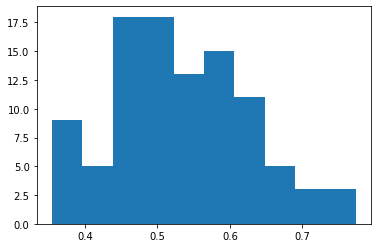

In [60]:
plt.figure()
plt.hist(accs_10)

# Our model

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

### MLP

In [62]:
model = Sequential()
model.add(Dense(1000, activation='relu', input_dim=X_train.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=10)

history = model.fit(X_train, 
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=128,
                    callbacks=[es],
                    shuffle=True)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 66532 samples, validate on 16634 samples
Epoch 1/100
66532/66532 [==============================] - 15s 232us/step - loss: 0.5780 - accuracy: 0.7044 - val_loss: 0.5495 - val_accuracy: 0.7235
Epoch 2/100
66532/66532 [==============================] - 13s 193us/step - loss: 0.5527 - accuracy: 0.7174 - val_loss: 0.5426 - val_accuracy: 0.7217
Epoch 3/100
66532/66532 [==============================] - 14s 205us/step - loss: 0.5446 - accuracy: 0.7218 - val_loss: 0.5390 - val_accuracy: 0.7244
Epoch 4/100
66532/66532 [==============================] - 14s 216us/step - loss: 0.5411 - accuracy: 0.7231 - val_loss: 0.5373 - val_accuracy: 0.7242
Epoch 5/100
66532/66532 [==============================] - 14s 205us/step - loss: 0.5375 - accuracy: 0.7249 - val_loss: 0.5429 - val_accuracy: 0.7188
Epoch 6/100
66532/66532 [==============================] - 14s 205us/step - loss: 0.5352 - accuracy: 0.72

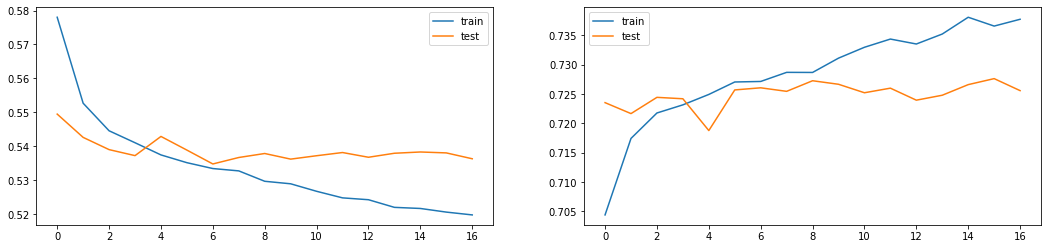

In [63]:
fig, ax = plt.subplots(1, 2, figsize=[18, 4])
ax = ax.flatten()

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].legend()

ax[1].plot(history.history['accuracy'], label='train')
ax[1].plot(history.history['val_accuracy'], label='test')
ax[1].legend()
plt.show()

In [64]:
y_pred = (model.predict(X_test) >= .5)*1

acc_1 = accuracy_score(y_test, y_pred)
prec_1 = precision_score(y_test, y_pred)
rec_1 = recall_score(y_test, y_pred)
f1_1 = f1_score(y_test, y_pred)

print("Accuracy: ", acc_1)
print("Precision: ", prec_1)
print("Recall: ", rec_1)
print("F1: ", f1_1)

Accuracy:  0.6804173236105636
Precision:  0.04509252313078269
Recall:  0.7116219415943172
F1:  0.08481093029818455


### LSTM

In [65]:
n_steps = 8
n_cols_X = len(cols_data)
n_cols_y = 1

X_train = X_train.reshape(-1, n_steps, n_cols_X)
X_test = X_test.reshape(-1, n_steps, n_cols_X)

y_train = np.array([arr[-1] for arr in y_train.reshape(-1, n_steps, n_cols_y)])
y_test = np.array([arr[-1] for arr in y_test.reshape(-1, n_steps, n_cols_y)])

ValueError: cannot reshape array of size 23419264 into shape (8,352)

In [ ]:
model = Sequential()
model.add(LSTM(1000, input_shape=(n_steps, n_cols_X)))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', 
                   mode='min', 
                   verbose=1, 
                   patience=10)

history = model.fit(X_train, 
                    y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=128,
                    callbacks=[es],
                    shuffle=True)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[18, 4])
ax = ax.flatten()

ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='test')
ax[0].legend()

ax[1].plot(history.history['acc'], label='train')
ax[1].plot(history.history['val_acc'], label='test')
ax[1].legend()
plt.show()

In [ ]:
y_pred = (model.predict(X_test) >= .5)*1

acc_4 = accuracy_score(y_pred, y_test)
prec_4 = precision_score(y_pred, y_test)
rec_4 = recall_score(y_pred, y_test)

print("Accuracy: ", acc_4)
print("Precision: ", prec_4)
print("Recall: ", rec_4)